This notebook was created by Donna Faith Go.

In [7]:
# standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# change point detection
import roerich
from roerich.change_point import ChangePointDetectionClassifier

# Time Series Segmentation

## Change point detection (CPD)

In this module, I will try to implement Roerich. 
This is a python library for change point detection in time series data.
[This is the documentation](https://github.com/HSE-LAMBDA/roerich).

Notes for self:
1. `cps_true` is for the actual points where there is a change in the time series. `X` is for the points that they are supposed to predict.
2. options for `base_classifier`: 'logreg', 'qda', 'dt', 'rf', 'mlp', 'knn', 'nb'
3. options for `metric`:'klsym', 'pesym', 'jsd', 'mmd', 'fd'

### Sample Simulation

This simulation is from the documentation.

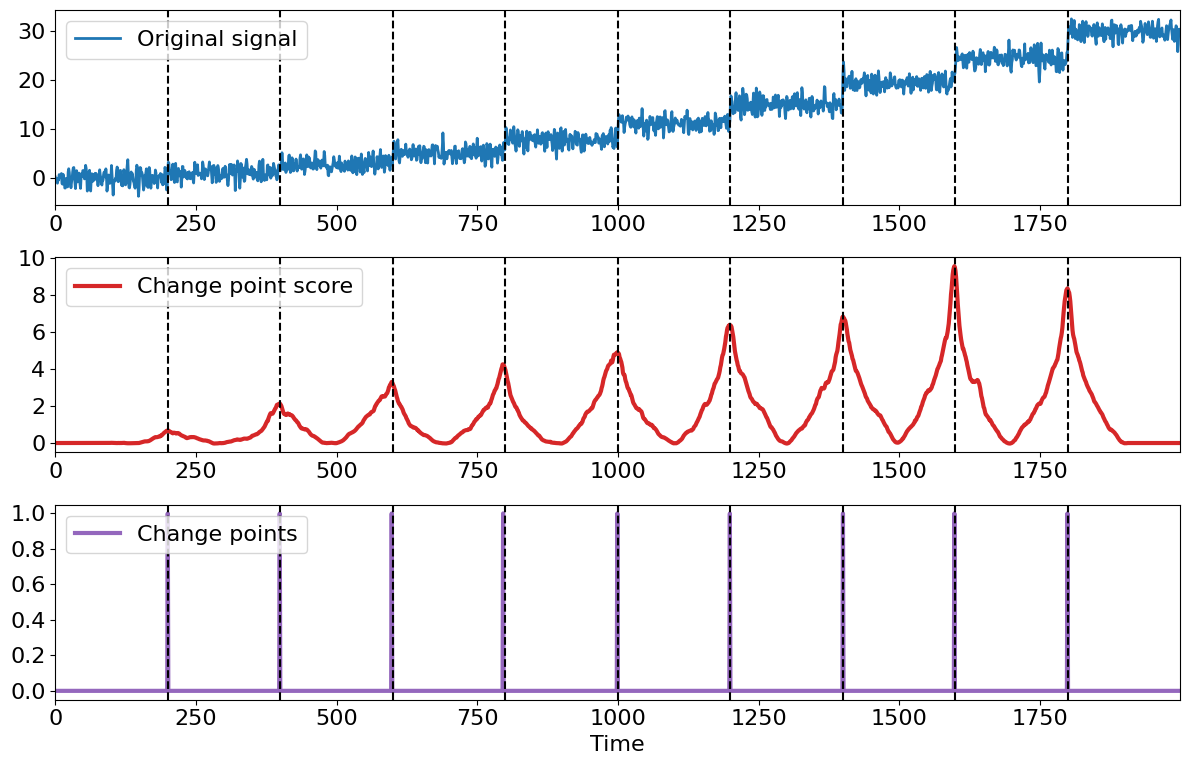

In [8]:
# generate time series
X, cps_true = roerich.generate_dataset(period=200, N_tot=2000)

# detection 
cpd = ChangePointDetectionClassifier(
    base_classifier='mlp', metric='klsym', window_size=100
)
score, cps_pred = cpd.predict(X)

# visualization
roerich.display(X, cps_true, score, cps_pred)

## Boundary Detection

## State Detection

## Learnings

Here are a few things I have learned:
1. 

## References

Research articles:
1. [Unsupervised Time Series Segmentation: A Survey on Recent Advances](https://www.sciopen.com/article/10.32604/cmc.2024.054061)

Medium articles:
1. [Change Point Detection in Time Series](https://medium.com/@sztistvan/change-point-detection-in-time-series-using-chatgpt-22cc9172a130)